# Multilayer networks

In the last subject, we learned about neural networks and saw the basic TensorFlow tools to build them. So far, we created networks with a single layer of neurons which are equivalent to linear, logistic or softmax regressions. In this unit, we will see that we can build more powerful models by simply adding layers of neurons with nonlinear activation functions. In the second part of this unit, we will implement a 2-layer neural network using TensorFlow to classify images from the MNIST data set.

The idea behind multilayer networks is to add layers of neurons between the input and the output layer. Here is an illustration of a simple multilayer network with three input neurons, two hidden layers with respectively two and three hidden units, and an output layer with two neurons.

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    ### force CPU on tensorflow

In [ ]:
from IPython.display import Image
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2752/multilayer.svg')

The goal of these hidden layers is to convert the input into a set of useful features which are then combined in the output layer to compute predictions. In other words, multilayer networks do not only learn to combine features but also learn these features by themselves. The idea is that each intermediate layer combines its inputs into a set of higher-level features that are then used in the next layer and so on. To achieve this, networks use **activation functions** which are simply functions that each neuron applies to its output.

### Activation functions

We saw in the last subject that each neuron computes its output by multiplying the signal sent by its input neurons with its synaptic weights and by adding the neuron bias. In the multilayer neural network case, we can express the output $ x_{j}^{\left(l\right)}$ of the j-th neuron of layer 
l
 with the following expression.
 
$$
x_{j}^{\left(l\right)}=\sum_{i}w_{i,j}^{\left(l\right)}x_{i}^{\left(l-1\right)}+b_{j}^{\left(l\right)}
$$

In this formula, we multiply the signal from each neuron from the previous layer 
x
(
l
−
1
)
i
 with the corresponding synaptic weight 
w
(
l
)
i
,
j
 and add the neuron bias 
b
(
l
)
j
. In multilayer networks, we apply an activation function 
ϕ
 to the output of each neuron.
 
 $$ x_{j}^{\left(l\right)}=\phi\left(\sum_{i}w_{i,j}^{\left(l\right)}x_{i}^{\left(l-1\right)}+b_{j}^{\left(l\right)}\right)$$
 
Activation functions and hidden layers are really at the heart of neural networks. In fact, it's possible to show that a network with a single hidden layer can approximate any continuous function. This is called **the universal approximation theorem**. If you want to learn more about it, we highly recommend reading chapter 4 of the Neural Networks and Deep Learning (NNDL) book which gives a visual explanation of the theorem. http://neuralnetworksanddeeplearning.com/chap4.html

### Sigmoid and ReLU activation

There are many possible activation functions. For instance, we can use the sigmoid function that we saw in the unit about logistic regressions.

$$ f\left(x\right)=\frac{1}{1+e^{-x}}$$

Here is a plot of the function for an input between -6 and +6.

In [ ]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2751/sigmoid.svg')

**One issue with the sigmoid function is that its derivative is close to zero (the curve is flat) when the input is very large or very small. Hence, the gradient update will be very small when updating the weights with gradient descent and the learning process becomes slow**. This is called the **vanishing gradient problem.**

Another popular activation function is the **Rectified Linear Unit (ReLU).**
$$ f\left(x\right)=\max\left(0,x\right)$$
The function is zero when 
x
 is negative and equal to 
x
 when it's positive.

In [ ]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2750/relu.svg')

One of the advantages of the ReLU activation function is that it's easy to implement and it seems to accelerate the learning process compared to the sigmoid one. You can take a look at this page if you want to learn more about activation functions. http://cs231n.github.io/neural-networks-1/#actfun

### Backpropagation

In the last course, we learned about the **gradient descent method** which updates the model parameters by computing the partial derivate of the loss function with respect to each parameter. In neural networks, **we use the same idea to update the weights and biases** of each neuron in our network. In practice, **deep networks have a lot of parameters and it would be very inefficient to compute the partial derivative of each weight individually.** **However, there is a technique called backpropagation** which can solve this issue. To avoid doing redundant computations, the backpropagation algorithm computes the error at the ouput neurons and propagates this information back through the network to compute the partial derivates layer after layer.

In [ ]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2749/backward-prop.svg')

Backpropagation is usually performed internally by the deep learning framework. For instance, when using **the GradientDescentOptimizer object, TensorFlow will automatically compute the gradients in an efficient way using the backpropagation algorithm**. If you want to learn more about the mathematics behind backpropagation, you can take a look at chapter 2 of the NNDL book. http://neuralnetworksanddeeplearning.com/chap2.html

### Weights initialization

So far, we initialized the synaptic weights of each neuron to zero. This sounds reasonable if we standardized the data since we expect some weights to be positive, some to be negative, but in average, centered around zero. **In multilayer networks, initializing the weights to a constant value (e.g., zero or one) is a bad idea because it makes all hidden units of a layer compute the exact same output**. In that case, gradient descent will compute the same gradient updates and we will end up with copies of the hidden units with the same weight values.

One solution is to use a normal distribution to **sample small random numbers.** That way, each hidden neuron will start with different weights and will occupy a different role in our network. In practice, we often use the truncated normal distribution which drops values whose magnitude is more than 2 standard deviations away from the mean. For instance, here is the truncated normal distribution with a standard deviation of 0.01

In [ ]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2748/truncated-normal.svg')

Ideally, we want to calibrate this standard deviation such that each neuron computes an output in a reasonable range for its activation function. When there are no activation function (e.g., in the output layer), it's recommended to set the standard deviation to the inverse of the square root of the number of input neurons 
n
. $$ \text{std}=\frac{1}{\sqrt{n}} $$

For layers with ReLU activations, the formula is a bit different.

$$ \text{std}=\sqrt{\frac{2}{n}} $$

We won't go into the derivation of these two formulas, but you can take a look at this page if you want to learn more about it. http://cs231n.github.io/neural-networks-2/#init


### TensorFlow implementation
---------

Now that we know the basic idea behind multilayer neural networks, let's go through a concrete example. In this second part, we will implement a 2-layer neural network with 16 hidden units in the hidden layer to classify images from the MNIST data set.

Let's start by creating the TensorFlow graph.

In [7]:
import tensorflow as tf

# Create a new graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 784])
    y = tf.placeholder(dtype=tf.int32, shape=[None])

    # Hidden layer with 16 units
    W1 = tf.Variable(initial_value=tf.truncated_normal(
        shape=[784, 16], # Shape
        stddev=(2/784)**0.5, # Calibrating variance
        seed=0
    ))
    b1 = tf.Variable(initial_value=tf.zeros(shape=[16]))

    # Output layer
    W2 = tf.Variable(initial_value=tf.truncated_normal(
        shape=[16, 10], # Shape
        stddev=1/16**0.5, # Calibrating variance
        seed=0
    ))
    b2 = tf.Variable(initial_value=tf.zeros(shape=[10]))

    # Compute logits
    hidden = tf.nn.relu( # ReLU
        tf.add(tf.matmul(X, W1), b1))
    logits = tf.add(tf.matmul(hidden, W2), b2)

C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In this code, we create a matrix of weights and vector of biases for each layer. The input layer has 784 input neurons which correspond to the pixels in the 28 by 28 grayscale images from the MNIST database. This input layer is connected to an intermediate hidden layer with 16 units. Hence, the shape of the weight matrix of the hidden layer is 
(
784
,
16
)
 and it bias vector has 16 elements. We create a second weight matrix to connect the hidden and output layers. Since there are ten output units, its shape is 
(
16
,
10
)
.

Finally, we compute the output of the hidden layer by multiplying the input and the weight matrices, add the bias and apply the ReLU activation function with the relu() function. Then, we compute the output of the network using this hidden tensor.

Note that we initialize the weights using the truncated_normal() function and calibrate the standard deviation using the formulas from above. For the output layer, we use the first formula since it has no activation function, but use the second one for the hidden layer since it uses the ReLU activation.

It's not really convenient to work with the code from above because the number of hidden units is repeated at different places.

- The shape of W1
- The shape of b1
- The shape of W2
- The standard deviation of W2


**To solve this issue, we can use the dense() function from the layers module and the TensorFlow initializers.**

In [8]:
# Redefine the graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 784])
    y = tf.placeholder(dtype=tf.int32, shape=[None])

    # Hidden layer with 16 units
    hidden = tf.layers.dense(
        X, 16, activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )

    # Output layer
    logits = tf.layers.dense(
        hidden, 10, activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )

This time, we only have to write once the number of units in each layer which is more convenient if we want to experiment with it, e.g., try different sizes for the hidden layer. We define each fully-connected layer with the dense() function which takes the input data, the number of output units, the activation function and the weights and bias initializers. We use the zeros_initializer() to initialize the biases to zero and the variance_scaling_initializer() to initialize the weights using the formulas from above. Note that we assign names to each layer. These names will make it easier to access the different layers and their elements.

The dense() function creates the weights and biases variables with the appropriate shape and initialize them using the specified initializers. **We can inspect the variables from the graph using the trainable_variables() function.**

In [9]:
with graph.as_default():
    # Get variables in the graph
    for v in tf.trainable_variables():
        print(v)


<tf.Variable 'hidden/kernel:0' shape=(784, 16) dtype=float32_ref>
<tf.Variable 'hidden/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'output/kernel:0' shape=(16, 10) dtype=float32_ref>
<tf.Variable 'output/bias:0' shape=(10,) dtype=float32_ref>


Note that it's possible to retrieve these variables using the variable_scope() and the get_variable() function.

In [10]:
with graph.as_default():
    # Get weights/biases of the hidden layer
    with tf.variable_scope('hidden', reuse=True):
        W1 = tf.get_variable('kernel')
        b1 = tf.get_variable('bias')

    # Get weights/biases of the output layer
    with tf.variable_scope('output', reuse=True):
        W2 = tf.get_variable('kernel')
        b2 = tf.get_variable('bias')

### Loss function and training operation

Now that the different layers of our neural network are specified, we can move on and define the loss function and training operations using the code from the previous units.


In [11]:
with graph.as_default():
    # Loss fuction: mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))

    # Gradient descent
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

### Train network

Let's train the network. First, we have to load the MNIST images, split them into train and validation sets and standardize the features using a StandardScaler transformer from Scikit-learn. The network is a bit larger this time since it has an additional hidden layer with 16 units. For this reason, we will train it using a slightly larger data set with 20 thousand images. You can download it from the resource section.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load data
with np.load('mnist-20k.npz', allow_pickle=False) as npz_file:
    # Load items into a dictionary
    mnist = dict(npz_file.items())

# Create train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    # Convert uint8 pixel values to float
    mnist['data'].astype(np.float32),
    mnist['labels'],
    test_size=500, random_state=0)

# Rescale train and validation data
scaler = StandardScaler()
X_train_rescaled = scaler.fit_transform(X_train)
X_valid_rescaled = scaler.transform(X_valid)

In [13]:
mnist

{'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'labels': array([5, 0, 4, ..., 1, 4, 2])}

This time, we will train the network using the entire data set several times. In the machine learning jargon, **one pass of training through the entire training set is called an epoch**. In practice, we usually shuffle the data before each epoch to get better results. Let's modify our get_batches() function from the previous unit.

In [14]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In this code, we create and shuffle a list of indexes and use it to iterate through our training data by small random batches.

Finally, let's train our network during 50 epochs.

In [15]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(50):
        # Accuracy values (train) after each batch
        batch_acc = []

        # Get batches of data
        for X_batch, y_batch in get_batches(X_train_rescaled, y_train, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.01 # Learning rate
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid_rescaled,
            y: y_valid
        })
        valid_acc_values.append(valid_acc)

        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))

    # Weights of the hidden and output layers
    weights_hidden = W1.eval()
    weights_output = W2.eval()

Epoch 1 - valid: 0.796 train: 0.631 (mean)
Epoch 2 - valid: 0.888 train: 0.849 (mean)
Epoch 3 - valid: 0.900 train: 0.881 (mean)
Epoch 4 - valid: 0.916 train: 0.897 (mean)
Epoch 5 - valid: 0.918 train: 0.906 (mean)
Epoch 6 - valid: 0.922 train: 0.914 (mean)
Epoch 7 - valid: 0.920 train: 0.919 (mean)
Epoch 8 - valid: 0.922 train: 0.923 (mean)
Epoch 9 - valid: 0.934 train: 0.926 (mean)
Epoch 10 - valid: 0.932 train: 0.929 (mean)
Epoch 11 - valid: 0.930 train: 0.932 (mean)
Epoch 12 - valid: 0.938 train: 0.934 (mean)
Epoch 13 - valid: 0.940 train: 0.936 (mean)
Epoch 14 - valid: 0.942 train: 0.939 (mean)
Epoch 15 - valid: 0.944 train: 0.941 (mean)
Epoch 16 - valid: 0.942 train: 0.943 (mean)
Epoch 17 - valid: 0.944 train: 0.944 (mean)
Epoch 18 - valid: 0.944 train: 0.947 (mean)
Epoch 19 - valid: 0.942 train: 0.947 (mean)
Epoch 20 - valid: 0.944 train: 0.949 (mean)
Epoch 21 - valid: 0.946 train: 0.950 (mean)
Epoch 22 - valid: 0.948 train: 0.951 (mean)
Epoch 23 - valid: 0.946 train: 0.952 (mea

In this code, we save the accuracy on each batch of training data and compare its mean to the accuracy on the validation set. This is a way to monitor overfitting and decide when to stop the network, i.e., the number of epochs to run. Finally, we save the trained weights with eval().

Let's plot the validation accuracy after each epoch.

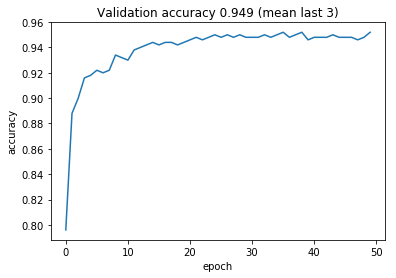

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:]) # last three values
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

This time, we get an accuracy of 95% which is a lot better than our softmax network from the last subject with 85%.

### Visualize weights

Finally, let's visualize the weights of the 16 hidden units using the code from the previous unit.


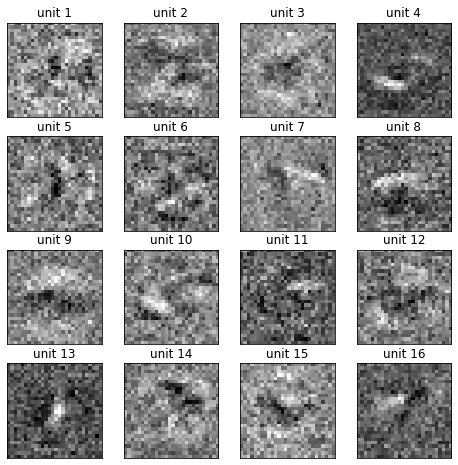

In [17]:
# Create figure with 16 subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

# Plot the weights of the 16 hidden units
for i, axis in enumerate(axes.flatten()):
    # Get weights of i-th hidden unit
    weights = weights_hidden[:, i]

    # Reshape into 28 by 28 array
    weights = weights.reshape(28, 28)

    # Plot weights
    axis.set_title('unit {}'.format(i+1))
    axis.imshow(weights, cmap=plt.cm.gray_r) # Grayscale
    axis.get_xaxis().set_visible(False) # Disable x-axis
    axis.get_yaxis().set_visible(False) # Disable y-axis

plt.show()

As we can see, the hidden units detect specific shapes that are then combined in the output layer.

Let's see how by printing the weights matrix from the output layer.

In [18]:
import pandas as pd

# Output layer weights
pd.DataFrame(
    weights_output,
    index=['unit {}'.format(i+1) for i in range(16)],
    columns=['digit {}'.format(i) for i in range(10)],
)

,digit 0,digit 1,digit 2,digit 3,digit 4,digit 5,digit 6,digit 7,digit 8,digit 9
unit 1,-0.151154,0.284383,0.172240,0.446757,-0.713837,-0.183502,0.480000,0.116505,0.348728,-0.560343
unit 2,-0.533486,-0.624569,0.205263,-0.056235,-0.039790,-0.083849,-0.584665,1.024174,-0.344761,-0.045943
unit 3,0.073382,0.799233,-0.129844,-0.049881,0.641498,0.478644,-0.723321,-0.508682,-0.525338,0.611302
unit 4,-0.272541,0.319896,-0.086140,0.961810,0.315077,1.009274,-0.286930,-0.434322,-0.607752,0.439435
unit 5,-0.391177,0.912025,-0.416022,-0.429280,-0.021465,-0.192731,0.417162,0.325653,0.743411,0.002196
unit 6,-0.133980,-0.484260,0.186193,0.347374,-0.065938,-0.113913,-0.330738,-0.504146,0.871023,-0.370285
unit 7,-0.162729,-0.269187,-0.383834,-0.803973,-0.550541,0.650970,0.613403,-0.133621,0.655968,-0.386253
unit 8,-0.093046,0.015065,1.257029,-0.055928,-0.113261,0.205466,0.349967,-0.395460,-0.334838,-0.443182
unit 9,0.058085,-0.596844,0.651317,-0.048199,0.510600,-0.239703,0.634887,-0.066740,-0.398665,-0.893872
unit 10,-0.225225,-0.145421,-0.133121,0.659437,-0.405561,0.560544,-0.709347,-0.281558,0.334449,0.198543


This weights matrix tells us how each output neuron computes its activation. For instance, we can see that the 4th hidden unit is used by the output neurons for digits 3, 5 and 9 which makes sense since they all have the rounded curve at the bottom of the image learned by this hidden unit.

### Summary

In this unit, we saw the idea behind multilayer networks such as hidden layers and activation functions, and saw how to implement one using TensorFlow. In practice, it's common to build 2- or 3-layer networks with this architecture of dense or fully-connected layers neurons. **These networks are very powerful but can easily overfit the training data**. In the next unit, we will learn about **dropout** which is a very efficient way to reduce overfitting in neural networks.

### Q&A


**Why simple activation functions as ReLU improve network learning?
Could you please explain why such simple activation function a ReLU is useful for the network training? When do we need to apply them and how to choose one?**

> The activation functions in the hidden layers, such as Sigmoid and ReLU, introduce non-linearity in the model. Hence, they help to solve non-linear problems and extract non-linear features (e.g. classification with non-linear separation between the classes). If we just concatenate the hidden layers in a neural network without activation functions, the overall model will be mathematically equivalent to a single-layer linear model. This is because 
w
l
(
w
l
−
1
x
+
b
l
−
1
)
+
b
l
 will be equivalent to a single layer linear operation.

> Indeed, it is surprising that a simple function like Sigmoid or ReLU is enough. There is some theory behind this in case you are interested. In fact, any activation function that looks like a smooth step-function is useful to introduce non-linearity and learn a complicated linear model. This is what is called the Universal Approximation Theorem in deep learning. A simple visualization of this theorem is available here.

> You should always use activation functions for hidden layers in the neural network, otherwise your network will be the same as a simple linear model (linear regression or logistic regression). Whether to choose Sigmoid, ReLU, Tanh (tangent hyperbolic), or any other function for the activation of the hidden layers depends on the data and specific setup. The type of the activation function is one of the hyperparameters that you can tune. A common choice based on previous experimentation is the ReLU function. It was proven that ReLU is numerically more stable than Sigmoid with very deep neural networks. This is because ReLU suffers less from the Vanishing Gradient Problem, as it is saturated from the left-side only. You can stick with ReLU for the hidden layers. However, note that the activation function at the output layer depends on the task and you don't have much freedom there. If the task is a binary classification, then the output activation is Sigmoid. If it is a multi-class classification, the output activation is Softmax.

> PS: The theoretical explanation of the Universal Approximation Theorem and Vanishing Gradient Problem is beyond the scope of this course. This is just to give you exposure if you are interested.



**The exercise suggests that we should test different architectures and hyper parameters. However, when I try to create a placeholder for the number of neurones in the hidden layer, and pass it as a such to the tf.layers.dense(), the same way we do with X, I get an error.
Is there a more efficient way to look for the optimal number of hidden neurones rather than re-writing the entire graph, and changing the names of variables?**

> That is correct, with the current TensorFlow implementation you can not pass a placeholder to the units in tf.layers.dense() as we did for the learning rate. This is because it alters the whole graph. For that, you need to create a graph each time in the grid search loop. Here is a pseudo-code:

for parameter in grid: # ----> loop over the hyperparameters

    # Create new graph
    tf.reset_default_graph()
    graph = tf.Graph()
    with graph.as_default():
       ...... # ----> Define all layers
       hidden = tf.layers.dense(X, units=parameter) # ----> set the hyerparameter
       ......

    # Start a session
    with tf.Session(graph=graph) as sess:
       ....
> You will see later with the high-level Keras API, such tuning becomes easier because you will not need to define a graph and then run a session separately.


### Exercise 4-8-1 and 4-8-2

# Dropout and L2 regularization

In this unit, we will learn about **dropout** as an efficient **regularization technique to reduce overfitting** in neural networks. In the second part of the unit, we will also see how to implement 
**L
2
 regularization** using TensorFlow.
 
# Dropout
The idea behind dropout is to randomly deactivate some neurons during the training. Here is an illustration of dropout applied to the hidden layer of a 2-layer neural network.

In [22]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2757/dropout.svg', width = 300)

This image shows dropout applied with a rate of 0.5 which means that the network randomly deactivate half of the neurons (in white) from the hidden layer at each training step. That way, the neurons in the output layer cannot learn complex rules that depend on all the neurons from the hidden layer.

Let's see how to apply dropout to the network from the previous unit.

### TensorFlow implementation
Let's start by defining the first layer using the code from the previous unit. This time, we will try to improve our results by increasing the number of hidden units to 64 while avoiding overfitting using dropout.

In [23]:
import tensorflow as tf

# Create a new graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 784])
    y = tf.placeholder(dtype=tf.int32, shape=[None])

    # Hidden layer with 64 units (ReLU)
    hidden = tf.layers.dense(
        X, 64, activation=tf.nn.relu,
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )

We can now apply dropout to the hidden layer with the dropout() function from the layers module. The function takes the tensor of output values, the dropout rate and a seed number to get deterministic results. Again, dropout is a method to reduce overfitting during the training process. In particular, we want **to deactivate it when using the network to predict some values**. To achieve this, we pass a boolean training placeholder to the function which indicates when we are training the network and when not.

In [24]:
with graph.as_default():
    # Create training placeholder
    training = tf.placeholder(dtype=tf.bool)

    # Apply dropout
    hidden = tf.layers.dropout(
        hidden, rate=0.5, seed=0, training=training)

In [25]:
with graph.as_default():
    # Output layer
    logits = tf.layers.dense(
        hidden, 10, activation=None,
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )

    # Hidden layer weights
    with tf.variable_scope('hidden', reuse=True):
        W1 = tf.get_variable('kernel')

    # Loss fuction: mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))

    # Gradient descent
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

### Train network

Let's train the network. Again, we load the data from the mnist-20k.npz archive, split it into train and validation sets and standardize it using a StandardScaler.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load data
with np.load('mnist-20k.npz', allow_pickle=False) as npz_file:
    # Load items into a dictionary
    mnist = dict(npz_file.items())

# Create train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    # Convert uint8 pixel values to float
    mnist['data'].astype(np.float32),
    mnist['labels'],
    test_size=500, random_state=0)

# Rescale input data
scaler = StandardScaler()
X_train_rescaled = scaler.fit_transform(X_train)
X_valid_rescaled = scaler.transform(X_valid)

# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

We can now train it using the code from the previous unit. **This time, we set training to True when running the training operation train_op and set it to False when evaluating the validation accuracy**.

In [30]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(50):
        # Accuracy values (train) after each batch
        batch_acc = []

        # Get batches of data
        for X_batch, y_batch in get_batches(X_train_rescaled, y_train, 256):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.1, # Learning rate
                training: True # Apply dropout
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid_rescaled,
            y: y_valid,
            training: False # Do not apply dropout
        })
        valid_acc_values.append(valid_acc)

        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))

    # Weights of the hidden layer
    weights_hidden = W1.eval()


Epoch 1 - valid: 0.900 train: 0.692 (mean)
Epoch 2 - valid: 0.922 train: 0.832 (mean)
Epoch 3 - valid: 0.926 train: 0.857 (mean)
Epoch 4 - valid: 0.938 train: 0.871 (mean)
Epoch 5 - valid: 0.942 train: 0.883 (mean)
Epoch 6 - valid: 0.946 train: 0.887 (mean)
Epoch 7 - valid: 0.944 train: 0.893 (mean)
Epoch 8 - valid: 0.946 train: 0.900 (mean)
Epoch 9 - valid: 0.948 train: 0.899 (mean)
Epoch 10 - valid: 0.944 train: 0.904 (mean)
Epoch 11 - valid: 0.954 train: 0.910 (mean)
Epoch 12 - valid: 0.956 train: 0.911 (mean)
Epoch 13 - valid: 0.954 train: 0.913 (mean)
Epoch 14 - valid: 0.956 train: 0.917 (mean)
Epoch 15 - valid: 0.956 train: 0.916 (mean)
Epoch 16 - valid: 0.954 train: 0.917 (mean)
Epoch 17 - valid: 0.962 train: 0.918 (mean)
Epoch 18 - valid: 0.960 train: 0.925 (mean)
Epoch 19 - valid: 0.958 train: 0.924 (mean)
Epoch 20 - valid: 0.964 train: 0.925 (mean)
Epoch 21 - valid: 0.968 train: 0.927 (mean)
Epoch 22 - valid: 0.964 train: 0.927 (mean)
Epoch 23 - valid: 0.970 train: 0.928 (mea

This time, the training accuracy is always smaller than the validation one which makes sense since the network has access to only half of the hidden units. Let's plot the validation accuracy after each epoch.

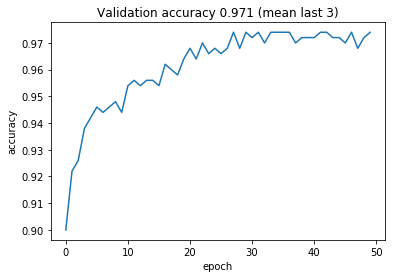

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:]) # last three values
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In practice, **it's common to use slightly larger networks than necessary and then reduce overfitting using dropout**. In our case, we have a small network with only 64 hidden units. For this reason, we don't get huge improvements. However, try to remove dropout by setting training to False in the train feed_dict. You should see that the training accuracy is above 99.9% after 50 epochs while the validation accuracy stays around 97%.

# L2 regularizazion

We can also reduce overfitting by adding an 
L
2
 regularization term to the loss function using l2_loss() from the the nn module.

In [31]:
with graph.as_default():
    # L2 term
    l2_term = tf.nn.l2_loss(W1)

    # Regularization strength
    alpha = tf.placeholder(dtype=tf.float32)

    # Loss function
    loss = mean_ce + alpha * l2_term

    # Training operation
    train_op = gd.minimize(loss)

In the code from above, we compute an l2_term and create an alpha placeholder to control the regularization strength.

Let's re-train our network using the code from above. This time, we have to set the regularization strength during training by adding an alpha entry in the feed_dict.

In [34]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(50):
        # Accuracy values (train) after each batch
        batch_acc = []

        # Get batches of data
        for X_batch, y_batch in get_batches(X_train_rescaled, y_train, 256):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.01, # Learning rate
                training: True, # Apply dropout
                alpha: 0.1 # Regularization strength
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid_rescaled,
            y: y_valid,
            training: False # Do not apply dropout
        })
        valid_acc_values.append(valid_acc)

        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))

    # Weights of the hidden layer
    weights_hidden = W1.eval()

Epoch 1 - valid: 0.686 train: 0.336 (mean)
Epoch 2 - valid: 0.802 train: 0.589 (mean)
Epoch 3 - valid: 0.834 train: 0.678 (mean)
Epoch 4 - valid: 0.860 train: 0.732 (mean)
Epoch 5 - valid: 0.872 train: 0.763 (mean)
Epoch 6 - valid: 0.892 train: 0.783 (mean)
Epoch 7 - valid: 0.900 train: 0.800 (mean)
Epoch 8 - valid: 0.906 train: 0.812 (mean)
Epoch 9 - valid: 0.912 train: 0.818 (mean)
Epoch 10 - valid: 0.912 train: 0.828 (mean)
Epoch 11 - valid: 0.914 train: 0.837 (mean)
Epoch 12 - valid: 0.914 train: 0.842 (mean)
Epoch 13 - valid: 0.916 train: 0.849 (mean)
Epoch 14 - valid: 0.918 train: 0.854 (mean)
Epoch 15 - valid: 0.920 train: 0.854 (mean)
Epoch 16 - valid: 0.920 train: 0.858 (mean)
Epoch 17 - valid: 0.918 train: 0.859 (mean)
Epoch 18 - valid: 0.920 train: 0.864 (mean)
Epoch 19 - valid: 0.920 train: 0.867 (mean)
Epoch 20 - valid: 0.922 train: 0.872 (mean)
Epoch 21 - valid: 0.926 train: 0.872 (mean)
Epoch 22 - valid: 0.926 train: 0.871 (mean)
Epoch 23 - valid: 0.924 train: 0.872 (mea

This time, we get an validation accuracy around 93%.

We can now take a look at a few hidden units using the tuned matrix of weights weights_hidden. We will plot the first 16 hidden units from the total 64 hidden ones.


### Q&A : 
I was wondering if we could fine tune lr and alpha using the grid search the same way we did in the previous courses ?

Or is it more complicated due to the batches loop + epochs loop ?

> Absolutely, the learning rate and regularization strength are hyperparameters worth tuning in a neural network. Other hyperparameters worth tuning are the number of layers, the number of neurons per layer, the type of activation functions used in each layer, and so on.

> Admittedly, hyperparameter tuning may be a bit easier to implement with the Keras API as Keras models are more compact and can be wrapped inside functions for testing a given set of hyperparameters. We will discuss the Keras API in a later unit. You can, of course, perform hyperparameter tuning using graphs, but your code will be more cumbersome.

> In all cases, you can tune hyperparameters using an approach similar to what we showed in previous units (e.g., see the Grid search using ParameterGrid unit). You can use a ParameterGrid object to define a grid of parameters for your grid search and then train a neural network for each combination of hyperparameters (this could be implemented using a simple for loop). You need to train your network on the training data and evaluate model performance on the validation data. For each set of hyperparameters, network "training" is the same as the one shown in the program: you compute a loss function on a mini-batch of data and use backpropagation to update model weights in the right direction. You repeat the process for several epochs until your model is trained long enough. At the end of the grid search, you can determine the best combination of hyperparameters based on model performance on the validation data. Eventually, once you have determined an optimal set of hyperparameters, you should measure generalization performance on the test data.

> Using the Keras API, you can also perform hyperparameter tuning using the GridSearchCV object from scikit-learn. In this case, you will need the KerasRegressor (for regressions) or the KerasClassifier objects (for classifiers) as wrappers around Keras models to be able to use them with GridSearchCV.


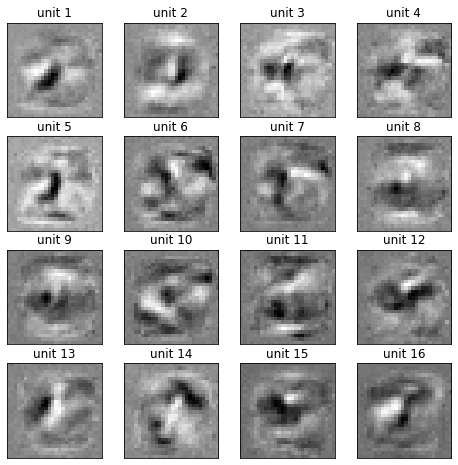

In [35]:
# Create figure with 16 subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

# Plot the weights of the first 16 hidden units
for i, axis in enumerate(axes.flatten()):
    # Get weights of i-th hidden unit
    weights = weights_hidden[:, i]

    # Reshape into 28 by 28 array
    weights = weights.reshape(28, 28)

    # Plot weights
    axis.set_title('unit {}'.format(i+1))
    axis.imshow(weights, cmap=plt.cm.gray_r) # Grayscale
    axis.get_xaxis().set_visible(False) # Disable x-axis
    axis.get_yaxis().set_visible(False) # Disable y-axis

plt.show()

As we can see, the templates of the hidden layer are much less noisy than before.

Summary
In this unit, we saw how to reduce overfitting in our neural networks using dropout and 
L
2
 regularization. **In the next one, we will learn about convolutional neural networks (CNN) which work really well to analyze images.**
 
> By turning the units/neurons on and off during training, the model learns simpler architecture. It will also learn not to become dependent on a single set of neurons and not to have too much cooperation between neurons (also know as co-adaptation in deep learning literature). This way we can see the dropout as a regularization method to overcome overfitting. It will help us even in a full-batch training when all the data is passed at once in each epoch, not necessarily in mini-batches. Mini-batch training with shuffling has the additional advantage of further randomizing the training. In this case, both the data and the active neurons are changing at each iteration. This will further improve the training and the generalization capabilities of the network as you have explained. Such stochasticity will also help the training algorithm not to get trapped in local minima.
In short, dropping some neurons at each iteration is itself useful. Combining this with mini-batch training will further improve the learning.



### Convolutional Neural Networks

In this unit, we will learn about convolutional neural networks (CNNs or ConvNets) which work particularly well with images. We will first learn about convolutional and max pooling layers and then see how to combine them into a ConvNet. In the second part of this unit, we will implement one for the MNIST data set using TensorFlow.

Convolutional neural networks use a particular type of layer called convolutional layer that can work on 3-dimensional volumes of data like images. The intuition behind those convolutional layers is that the important features are usually not specific to some locations of the image. For instance, if detecting lines is an important aspect of our network, we don't need to learn to detect lines at every location of the image independently. Instead, we could simply learn a line **detector that we slide over the image. This operation is called convolution.**

Let's take an example. Here is a 7x7 grid of input values with a 3x3 **kernel (also called filter)** that we use to detect patterns in the grid.

In [38]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2744/convex-input-kernel.png', width = 500)

The idea behind convolutional layers is to slide the kernel over the grid of input values to produce a grid of output values. In practice, we usually pad the image with zeros **(called zero-padding)** to align the center of the kernel and the corners of the grid.

In [39]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2743/convex-conv1.png', width = 500)

To compute the output value, we simply perform an element-wise multiplication between the kernel and the grid values at the current kernel location (in blue in the image) and sum the result.

We can then slide the kernel and compute the next output value. The **stride of the convolution defines how the kernel moves on the grid**. For instance, if the stride is 2, we will move our kernel by two positions each time. In this example, we will slide the kernel from left to right and top to bottom, but the result doesn't depend on the order.

In [40]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2742/convex-conv2.png', width = 500)

In this image, the kernel moved two positions to the right, and we get a second output value. We can continue to slide the kernel in this direction to obtain two more values before it reaches the end of the line.

In [41]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2741/convex-end-of-line.png', width = 500)

We can then continue to the next line which is the third one since the stride is 2 in both directions. Note that we sometimes write the stride by specifying the horizontal and vertical components. Using this notation, we are doing a convolution with a 2x2 stride.

In [42]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2740/convex-new-line.png', width = 500)

In this example, the output grid is smaller than the input one since the stride is 2. However, they would have the same dimensions with this zero-padding strategy if the stride was 1. **For this reason, we often call it the "same" padding strategy.**

The convolution continues until the kernel reaches the bottom right corner.

In [43]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2739/convex-last-position.png', width = 500)

In this example, the convolution reduced the 7x7 grid of input values into a 4x4 grid of outputs that we can then pass to an activation function. For instance, we can use the ReLU activation.

In [47]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2738/relu.png', width = 200)

Let's summarize: Convolutional layers learn kernels/filters that process the grid of input values using the convolution operation. More specifically, it learns the values or **weights** in those filters that multiply the grid of input values. Note that we also assign a **bias** term to each kernel in practice.



> How many parameters does the network have to learn in the example from above with the 7x7 input grid and the 3x3 kernel?

There are 10 parameters. It's important to understand that the number of parameters of the convolutional layer does not depend on the size of the input. In our case, the convolutional layer has a total of 10 parameters: the 3*3=9 kernel weighs and its bias term (which is zero in our example) independently of the size of the input grid.

### Depth of the convolutional layer

In the example from above, our convolutional layer has a single kernel, and we get a single grid of output values. In practice, we usually have several kernels that learn to detect different patterns in the input and hence get a different grid of outputs/activations for each one. For instance, we could have a kernel that detects horizontal lines and others that detect lines with different angles. **The depth of a convolutional layer refers to its number of kernels.**

Note that each kernel is independent. It learns its own weights and bias parameters and hence processes the input grid differently. For instance, if we add two kernels to the convolutional layer from above, we would get an **output volume** of size 4x4x3, i.e., three 4x4 output grids.

> What would be the number of parameters in this case?

30 in total - there are three kernels, each with ten parameters (the 3*3 = 9 kernel weights and the kernel bias).


At the beginning of the unit, we said that convolutional layers can work on **3-dimensional volumes** of data. In the example from above, kernels are 2-dimensional grids of values because the input is also 2-dimensional. However, we can easily generalize this to 3-dimensional inputs by adding a third dimension to the kernel equal to the input depth. For instance, if we are working on RGB images - three dimensional (height,width,3) input volumes of data - we would need to use (k,k,3) kernels where k is the kernel size. In this case, we would compute element-wise multiplication between the 3d kernel and input at its current height/width location during the convolution operation. Note that we would still slide the 3d kernel over the 3d input grid in the height/width dimensions and get a 2d grid of output values for each kernel.

> How many parameters would the network have to learn in the example from above if the input was a 3-dimensional RGB image? i.e., a 7x7 RGB input volume processed by three kernels of size 3x3.

84 in total. The input has a depth of 3 (one 7x7 grid per color channel, or a 7x7x3 input volume). Hence, we also need to use 3d kernels with a depth of 3. So, each kernel is a 3x3x3 grid of values with 28 parameters (3*3*3=27 weights and a bias). In total, the three kernels have 3*28=84 parameters.

Your answer
(3x3x3 kernel weighs + 1 kernel bias) x 3 kernels = 84


**To summarize, convolutional layers apply a set of kernels that detect different patterns in the input volumes. In that sense, the number of kernels is an important parameter in what the layer can learn.**

### Max pooling layers

In the example from above, the convolutional layer reduces the dimensions of the grid from 7x7 to 4x4 due to the stride of 2. In practice, **it's common to keep the dimensions of the input in the convolutional layer using the "same" zero-padding strategy with a stride of 1 and pass the output to a pooling layer which performs the down-sampling operation.**

The idea behind pooling layers is to slide a window over the input grid and combine the values in each window into one. One of the most common pooling operations is **max pooling** which computes the maximum of the values in each window. Let's take an example. Here is an illustration of the max pooling operation applied to the output of the convolutional layer from above. Note that there are no zero-padding this time.

In [49]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2737/convex-max-pooling.png', width = 350)

In this image, we use a 2x2 window and stride to get four non-overlapping windows and obtain the max pooling output by taking the maximum value in each window.

> What is the number of parameters in this max pooling layer with a 2x2 window and 2x2 stride?

Zero. Taking the maximum of a set of values doesn't depend on any external parameters! Max-pooling layers are just down-sampling their input - they are not learning anything.

Let's summarize: 
------
Convolutional layers learn kernels that process input volumes of arbitrary depth to detect different patterns. **In practice, we usually combine convolutional layers with a pooling operation to reduce the dimensions of the input**. In a typical scenario, we use small kernels in the convolutional layers (usually 3x3 and sometimes 5x5) and **keep the input dimensions using the "same" zero-padding with a stride of 1,** and **then reduce the input dimensions using a max pooling operation with 2x2 windows and stride**. Here is a video of the entire process with the example from above.

https://youtu.be/Y1ugnb0bobk

### Convolution arithmetic

We can compute the size of the output of the convolutional and pooling layers with the following formulas.

$$o_{\text{conv}}=\left\lfloor \frac{i+2p-k}{s}\right\rfloor +1\qquad o_{\text{pool}}=\left\lfloor \frac{i-k}{s}\right\rfloor +1$$
The first formula shows how to compute the size of the output of a convolutional layer given the size of its input 
i
, padding 
p
, kernel 
k
 and the stride 
s
. Note that it uses the floor function 
$$f
(
x
)
=
⌊
x
⌋$$
 which returns the largest integer smaller than or equal to 
x
, e.g., 
$$⌊
2.4
⌋
=
2
, 
⌊
−
0.4
⌋
=
−
1
, 
⌊
8
⌋
=
8$$
. For instance, in the example from above, we have 
i
=
7
, 
p
=
1
, 
k
=
3
, 
s
=
2
. Hence, the output size is 4.

$$o_{\text{conv}}=\left\lfloor \frac{7+2-3}{2}\right\rfloor +1=\left\lfloor 3\right\rfloor +1=4$$
The second formula shows how to compute the size of the output of a pooling layer given the size of its input 
i
, window 
k
 and the stride 
s
. In the example from above, we have 
i
=
4
, 
k
=
2
 and 
s
=
2
. Hence, the output is 2.

$$o_{\text{pool}}=\left\lfloor \frac{4-2}{2}\right\rfloor +1=\left\lfloor 1\right\rfloor +1=2$$

### Convolutional neural networks

In practice, we usually combine convolutional and max pooling layers to create **convolutional neural networks**. The idea is to start by detecting simple patterns in the first layers and combine them into higher-level ones with successive convolution and max pooling layers. We usually end up with a network that converts input volumes that have relatively large dimensions compared to their depth into deep output volumes with small dimensions. For instance, here is the network architecture that we will implement below to classify images from the MNIST data set.

In [52]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2736/mnist-cnn.png', width = 800)

The network has the following structure.

- Input layer with the 28x28 grayscale images from the MNIST database.
- Convolutional layer with sixteen 5x5 kernels, 2x2 stride, "same" padding and ReLU activation.
- Max pooling layer, 2x2 size and stride.
- Convolutional layer with sixteen 3x3 kernels, 1x1 stride, "same" padding and ReLU activation.
- Max pooling layer, 2x2 size and stride.
- Reshaping of the last layer to a 1-dimensional flat array.
- Fully-connected layer with 256 input units and ten output units.

In this case, we start with 28x28x1 input volumes (28x28 grayscale images) and end up with 4x4x16 (=256 values) output volumes after the second max pooling layer. This output volume should contain high-level features that we can then use in a fully-connected layer to produce the ten output digits.


> How many parameters does the first convolutional layer have?

It has 416 parameters. The layer has sixteen 5x5x1 kernels, i.e., 5x5 kernels that process input volumes of depth 1 (grayscale images). Hence, there are 16x(5x5x1) = 400 weights. Since each kernel has a bias, there is a total of 400 + 16 = 416 parameters.

> How many parameters does the first max pooling layer have?

It has no parameter. Max pooling layers simply reduce the height/width dimensions of the input using the max function.

> How many parameters does the second convolutional layer have?

It has 2,320 parameters. The layer has sixteen 3x3x16 kernels, i.e., 3x3 kernels that process 3-dimensional input volumes with a depth of 16 (the 16 output grids from the first layer). Hence, there are 16x(3x3x16) = 2,304 weights. Again, each kernel has a bias, and the total number of parameters is 2,304 + 16 = 2,320.

> How many parameters does the fully-connected layer have?

The layer has 2,570 parameters. It connects 256 input units (the flat output of the last pooling layer) to the 10 logits. Hence, the output layer has 2,560 weights and ten biases.

### TensorFlow implementation

We will now see how to implement the simple convolutional neural network from above using TensorFlow.

#### Data preprocessing

Let's start by loading and preprocessing the data. We saw in the previous unit that we can improve the learning process by centering the input values around zero. In our case, we are working with pixel values that range between 0 and 255. A common way to preprocess images before passing them to a ConvNet is to subtract 128 to each value and divide them by 255. With this simple procedure, we should get centered values that range between -0.5 and 0.5.

$$x_{\text{rescaled}}=\frac{x-128}{255}$$

Let's load and preprocess the images from mnist-20k.npz. You can download the archive from the resource section.

In [53]:
import numpy as np

# Load data
with np.load('mnist-20k.npz', allow_pickle=False) as npz_file:
    mnist = dict(npz_file.items())

# Convert pixels into floating point numbers
data = mnist['data'].astype(np.float32)

# Rescale pixel values between -0.5 and 0.5
data = (data - 128) / 255

In this code, we load the image pixels, convert them into floating point numbers and rescale them using the formula from above.

In this example, we will monitor the learning process using a validation set. We will use 19,500 images for training and the remaining 500 ones for evaluation. Let's create these train and validation sets.

In [54]:
from sklearn.model_selection import train_test_split

# Split into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    # Reshape images (28 by 28)
    data.reshape(-1, 28, 28, 1), # Single channel (grayscale)
    mnist['labels'],
    test_size=500, random_state=0
)

# Print shape
print('Train:', X_train.shape, y_train.shape)

print('Valid:', X_valid.shape, y_valid.shape)

Train: (19500, 28, 28, 1) (19500,)
Valid: (500, 28, 28, 1) (500,)


In this code, we reshape the flat matrix of image pixels back into 28x28x1 grids of values with the reshape() function from Numpy and get two 4-dimensional arrays of values X_train and X_test with respectively 19,500 and 500 images.

**Note: The last dimension, in this case representing the grayscale channel, is very important for ConvNets. It needs to be specified even if it only has one column, as is the case in our example.**

#### Convolutional layer
Let's build the graph. We will start by creating the placeholders for the images and labels.

In [55]:
import tensorflow as tf

# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1])
    y = tf.placeholder(dtype=tf.int32, shape=[None])

This time, the input X is a 4d tensor (n, 28, 28, 1) where n is the number of images that we inject into the graph and 1 is the number of channels of our input (i.e. one channel representing the grayscale values).

We can then create a first convolutional layer. To achieve this, we will use the conv2d() function from the nn module. The function takes the input values and a kernel variable with the kernel weights. Note that it expects 4d tensors in both cases.

- A [batch, in_height, in_width, in_channels] tensor for the input.
- A [filter_height, filter_width, in_channels, out_channels] tensor for the kernels.

We can pass the X placeholder from above for the input values, but we need to create the second tensor with the kernel weights.

In [56]:
with graph.as_default():
    # Kernel matrix
    kernel = tf.Variable(
        initial_value=tf.truncated_normal(
            shape=(5, 5, 1, 16), # Sixteen 5x5x1 kernels
            stddev=0.01, # Small standard deviation
            seed=0))

In this code, we create a Variable with the weights for the sixteen kernels and initialize it using a (truncated) normal distribution with a small standard deviation. Note that we have to specify the depth of the input values even if the images are 2-dimensional. For this reason, the shape of the kernels is 5x5x1 instead of 5x5, and the input images are 28x28x1 instead of 28x28.

We can now create the convolution operation with the conv2d() function. We can specify the stride and the padding with the stride and padding arguments. For the stride, we need to provide a list with one value for each dimension in the input, i.e., how the kernels move on the [batch, in_height, in_width, in_channels] input tensor. In our case, we set it to [1, 2, 2, 1] since we are doing a 2x2 convolution over the height/width axes.

In [57]:
with graph.as_default():
    # Convolutional layer
    conv = tf.nn.conv2d(
        X, kernel,
        strides=[1, 2, 2, 1], # Stride: 2
        padding='SAME' # "same" padding
    )

print(conv.shape) 

(?, 14, 14, 16)


The function creates a conv operation that produces sixteen 14x14 grids of values for each image. We can then add a variable with the biases and apply the activation function.

In [58]:
with graph.as_default():
    # Create biases (one per filter)
    biases = tf.Variable(initial_value=tf.zeros(shape=[16]))

    # Apply activation function
    conv = tf.nn.relu(conv + biases) # ReLU

Note that we create one bias for each kernel and add them to the output values using the + operator. TensorFlow will automatically add each bias to the relevant filter using broadcasting.

**Creating convolutional layers using the code from above can quickly become complex.** In particular with deep networks with several layers. For this reason, TensorFlow provides a **simplified conv2d()** function in its layers module that automatically creates all the variables and apply the relevant activation function. Let's redefine our network with this function.

In [59]:
# Redefine graph
graph = tf.Graph()

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1])
    y = tf.placeholder(dtype=tf.int32, shape=[None])

    # Convolutional layer (simplified tf version)
    conv = tf.layers.conv2d(
        X, # Input data
        filters=16, # 16 filters
        kernel_size=(5, 5), # Kernel size: 5x5
        strides=(2, 2), # Stride: 2
        padding='SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv' # Add name
    )

print(conv.shape)

(?, 14, 14, 16)


This time, we pass the input variable, the number of filters, the stride and padding, the activation function and an initializer for the kernel weights. It's interesting to note that we don't have to repeat any values. This makes the network architecture much easier to edit, e.g., change the number of kernels or their size.

### Max pooling layer
The layers module also provides a max_pooling2d() function to create max pooling layers. The function takes the 4d input tensor, the pool size, the stride, and padding.

In [60]:
with graph.as_default():
    # Max pooling layer
    pool = tf.layers.max_pooling2d(
        conv, # Convolution output
        pool_size=(2, 2), # Pool size: 2
        strides=(2, 2), # Stride: 2
        padding='SAME' # "same" padding
    )

print(pool.shape)

(?, 7, 7, 16)


As we can see, the max pooling layer reduced by half the dimensions of the input in the height/width axes and hence by 75% the number of values.

### Convolutional neural network
Let's add the second convolutional and max pooling layers on top of the first ones with the conv2d() and max_pooling2d() functions from the layer module.

In [61]:
with graph.as_default():
    # Convolutional layer
    conv2 = tf.layers.conv2d(
        pool, # Max pooling output
        filters=16, # 16 filters
        kernel_size=(3, 3), # Kernel size: 3x3
        strides=(1, 1), # Stride: 1
        padding='SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv2' # Add name
    )

    # Max pooling layer (2x2, stride: 2)
    pool2 = tf.layers.max_pooling2d(
        conv2, pool_size=(2, 2), strides=(2, 2), padding='SAME')

print(conv2.shape) 
print(pool2.shape)

(?, 7, 7, 16)
(?, 4, 4, 16)


This time, the convolutional layer doesn't modify the dimension of the input since it uses the "same" padding strategy with a stride of 1. On the other hand, the max pooling layer reduces its dimensions, and we get sixteen 4x4 grids (256 output values). In a typical ConvNet architecture, we use these high-level features to solve our task. In our example, we will combine these values into ten output logits with a fully-connected layer.

But first, we need to flatten the 4x4x16 output volumes into flat vectors. To achieve this we can use the reshape() function from TensorFlow.

In [62]:
with graph.as_default():
    # Flatten output into a (batch_size, 256) matrix
    flat_output = tf.reshape(pool2, [-1, 256])

print(flat_output.shape) # Prints: (?, 256)

(?, 256)


In this code, we pass the desired output shape to the function. This can be an issue in practice since it depends on the current ConvNet architecture. In particular, we would need to recompute and edit the number of features each time we modify the first convolutional and max pooling layers, e.g., increase the number of kernels, change their size and so on.

To avoid this, we can use the flatten(X) function from the contrib.layers module which automatically computes the shape of the input X and flattens the dimensions (except the first one which is the batch size).

In [63]:
with graph.as_default():
    # Flatten output
    flat_output = tf.contrib.layers.flatten(pool2)

print(flat_output.shape)

(?, 256)


Note that the contrib module from TensorFlow contains code that is likely to evolve in the next versions. For instance, the flatten() function from above was moved to the tf.layers module in version 1.4.

Now that we have a set of 256 features for each image, let's build the final classifier using a fully-connected layer.

In [64]:
with graph.as_default():
    # Output layer
    logits = tf.layers.dense(
        flat_output, 10, # Output units: 10
        activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='dense'
    )

print(logits.shape)

(?, 10)


Let's take a look at the variables in our graph with the trainable_variables() function.

In [65]:
with graph.as_default():
    # Get variables in the graph
    for v in tf.trainable_variables():
        print(v)

<tf.Variable 'conv/kernel:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'conv/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'conv2/kernel:0' shape=(3, 3, 16, 16) dtype=float32_ref>
<tf.Variable 'conv2/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(256, 10) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(10,) dtype=float32_ref>


Again, if we want to inspect some of the variables, we can obtain them with the variable_scope() and get_variable() functions. For instance, let's retrieve the kernel weights from the first convolutional layer to see how our low-level feature detectors look like after training.

In [66]:
with graph.as_default():
    # Kernel weights of the 1st conv. layer
    with tf.variable_scope('conv', reuse=True):
        conv_kernels = tf.get_variable('kernel')

print(conv_kernels.shape)

(5, 5, 1, 16)


Finally, let's define the loss function and the training operations. This time, **we will use the Adam optimizer. Adam is a very popular algorithm that was introduced in 2015**. It's now one of the default choices to optimize neural networks. We won't go into the details of how the algorithm works, but one of the key differences with stochastic gradient descent (SGD) is that it maintains a different learning rate for each parameter in the network.

TensorFlow provides an AdamOptimizer object in its train module. It has several parameters, but we will only adjust the principal learning rate with an lr placeholder.

In [67]:
with graph.as_default():
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))

    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

### Train network

In [68]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In [69]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(10):
        # Accuracy values (train) after each batch
        batch_acc = []

        for X_batch, y_batch in get_batches(X_train, y_train, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.001 # Learning rate
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid,
            y: y_valid
        })
        valid_acc_values.append(valid_acc)

        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))

    # Get 1st conv. layer kernels
    kernels = conv_kernels.eval()


Epoch 1 - valid: 0.934 train: 0.756 (mean)
Epoch 2 - valid: 0.966 train: 0.938 (mean)
Epoch 3 - valid: 0.960 train: 0.950 (mean)
Epoch 4 - valid: 0.968 train: 0.961 (mean)
Epoch 5 - valid: 0.982 train: 0.967 (mean)
Epoch 6 - valid: 0.974 train: 0.971 (mean)
Epoch 7 - valid: 0.982 train: 0.974 (mean)
Epoch 8 - valid: 0.980 train: 0.975 (mean)
Epoch 9 - valid: 0.980 train: 0.978 (mean)
Epoch 10 - valid: 0.978 train: 0.979 (mean)


In this code, we run the training operation and save the accuracy on each batch of data. After each epoch, we evaluate the network on the validation set and compare its validation accuracy to the mean of the train accuracy values. In our case, the train and validation accuracy values are close to each other which is a good sign that the network is not overfitting. At the end of the training process, we save the weights of the kernels from the first convolutional layer in a kernels variable to visualize them.

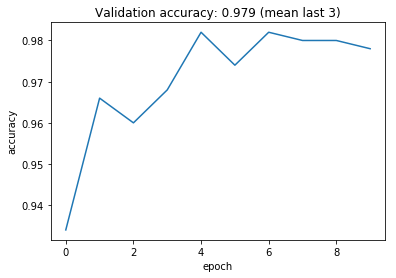

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy: {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:]) # Last three values
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

### Plot filters

Let's visualize the 16 kernels from the first layer. To achieve this, we need to extract the 5x5 kernel weights from the kernels variable which is an array of shape (5, 5, 1, 16).

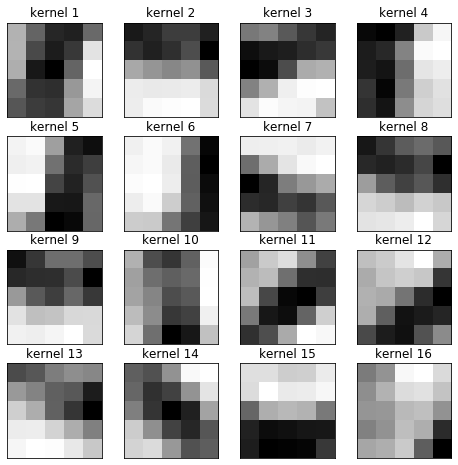

In [71]:
# Create figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

# Plot the 16 kernels from the first convolutional layer
for i, axis in enumerate(axes.flatten()):
    # Get i-th kernel
    kernel = kernels[:, :, :, i]

    # Kernels are 5x5x1 (height, width, channels)
    # Remove last dimension
    kernel = kernel[:, :, 0] # (5, 5) kernel

    # Plot kernel with imshow()
    axis.set_title('kernel {}'.format(i+1))
    axis.imshow(kernel, cmap=plt.cm.gray_r)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis

plt.show()

In this code, we create a 4x4 grid of subplots with the subplots() function from Pyplot which returns a 4x4 axes array with the subplot axes. We use the flatten() function to convert this 2-dimensional array into a 1-dimensional one with the 16 axes and then iterate through this array of axes with the Python enumerate() function which returns each axis and its index in the flat array, i.e., integers between 0 and 15. We use this index to extract the weights from the i-th kernel and plot them with the imshow() function.


### Summary

In this unit, we learned about convolutional neural networks and saw how to implement them in TensorFlow using the functions from its nn and layers modules. If you want to learn more about ConvNets, we highly recommend you to watch this presentation from Andrej Karpathy. https://www.youtube.com/watch?v=u6aEYuemt0M

In the next exercise, you will build a ConvNet for the CIFAR-10 data set. This is a good opportunity to experiment with different architectures and parameters, e.g., the number of kernels, their sizes, the stride, the number of convolutional layers and so on.

### Exercise
To see the effect of each kernel on the images, you can pick one from the validation set and plot the corresponding convolutional output conv. You should get a set of sixteen 14x14 output grids (also called activation or feature maps). This time, it's your turn to write the code!

4-8-3